In [15]:
import numpy as np
import pyccl as ccl
import sacc
from classy import Class
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../codes/montepython_cgg/montepython/')
from ccl_class_blcdm import CCL as CCLBLCDM


parsLCDM = {
        'n_s': 0.911657,
        'Omega_b': 0.03597189, 'A_s': 1.872275e-09, 'h': 0.8133244,
        'Omega_fld': 0, 'tau_reio': 0.08, 'Omega_cdm': 0.2160843,
        'output': 'mPk', 'z_max_pk': 8, 'P_k_max_1/Mpc': 10}

parsBLCDM = {'expansion_model': 'lcdm', 'parameters_smg': '0, 0', 'Omega_Lambda': 0,
        'gravity_model': 'mgclass_fs', 'Omega_smg': -1, 'expansion_smg': 0.7}

s = sacc.Sacc.load_fits('../../../data/cls_growth_SD_covG.fits')
d = s.mean
cov = s.covariance.covmat
errs = np.sqrt(np.diag(cov))

from scipy.interpolate import interp1d

def get_cl(cosmo, ls, ccl_tracers, n1, n2):
    ls_nodes = np.unique(np.geomspace(2, ls[-1], 30).astype(int)).astype(float)
    cls_nodes = ccl.angular_cl(cosmo,
                               ccl_tracers[n1],
                               ccl_tracers[n2],
                               ls_nodes)
    cli = interp1d(np.log(ls_nodes), cls_nodes,
                   fill_value=0, bounds_error=False)
    msk = ls >= 2
    cls = np.zeros(len(ls))
    cls[msk] = cli(np.log(ls[msk]))
    return cls

def get_dtype(s, tr1, tr2):
    if s.tracers[tr1].quantity == 'galaxy_shear':
        dt1 = 'e'
    else:
        dt1 = '0'
    if s.tracers[tr2].quantity == 'galaxy_shear':
        dt2 = 'e'
    else:
        dt2 = '0'
        
    dtype = f'cl_{dt1}{dt2}'
    if dt1 == 'e':
        dtype = f'cl_{dt2}{dt1}'
        
    return dtype

def get_indices_tracers(s, tr1, tr2):
    dtype = get_dtype(s, tr1, tr2)
    ind = s.indices(data_type=dtype,
                    tracers=(tr1, tr2))
    return ind

def plot_Cell_data_ax(ax, s, tracers):
    n1, n2 = tracers
    ind = get_indices_tracers(s, n1, n2)
    dtype = get_dtype(s, n1, n2)
    ell = s.get_tag('ell', data_type=dtype,
                    tracers=(n1, n2))
    d = s.mean
    errs = np.sqrt(np.diag(s.covariance.covmat))
    dl = d[ind]
    el = errs[ind]
    tl = th[ind]
    ax.errorbar(ell, dl, yerr=el, fmt='k.')
    ax.plot(ell, tl)
    ax.set_xscale('log')
    ax.text(0.82, 0.9, f'({n1},{n2})', ha='right',
            transform=ax.transAxes, fontsize=12)
    
def plot_Cell_th_ax(ax, s, tracers, th, label=None, color=None, **kwargs):
    n1, n2 = tracers
    ind = get_indices_tracers(s, n1, n2)
    dtype = get_dtype(s, n1, n2)
    ell = s.get_tag('ell', data_type=dtype,
                    tracers=(n1, n2))
    el = errs[ind]
    tl = th[ind]
    ax.plot(ell, tl, label=label, color=color, **kwargs)
    ax.set_xscale('log')
    
biasesSD = {'DESgc__0' : 1.48, 'DESgc__1' : 1.76, 'DESgc__2' : 1.78, 'DESgc__3': 2.19, 'DESgc__4': 2.23, 'eBOSS__0': 2.1, 'eBOSS__1': 2.5}

In [2]:
def get_pars_SD_BF():
    h = "#          Omega_b,        Omega_cdm,              A_s,              n_s,                h, parameters_smg__1, parameters_smg__2,    DESgc__0_gc_b,    DESgc__1_gc_b,    DESgc__2_gc_b,    DESgc__3_gc_b,    DESgc__4_gc_b,      DESgc__0_dz,      DESgc__1_dz,      DESgc__2_dz,      DESgc__3_dz,      DESgc__4_dz,          wl_ia_A,        wl_ia_eta,    DESwl__0_wl_m,    DESwl__1_wl_m,    DESwl__2_wl_m,    DESwl__3_wl_m,      DESwl__0_dz,      DESwl__1_dz,      DESwl__2_dz,      DESwl__3_dz,    eBOSS__0_gc_b,    eBOSS__1_gc_b"
    p = "3.751017e-02    1.935126e-01    1.895755e-09    8.884165e-01    8.969051e-01    3.389136e+02    7.860410e-01    1.276793e+00    1.559098e+00    1.550134e+00    1.905616e+00    1.947551e+00   -3.939741e-03   -3.044680e-03   -3.312189e-03   -7.631848e-04   -1.801574e-03    5.559673e-01   -1.009506e+00    3.313721e-02    2.561726e-03    5.405985e-02   -1.485136e-02   -2.263106e-02    3.724410e-03    7.347004e-03   -9.308793e-03    2.042809e+00    2.299619e+00"
    pname = h.replace('#', '').replace(' ', '').split(',')
    pval = [float(i) for i in p.split()]
    d = {}
    biases = {}
    for k, v in zip(pname, pval):
        if ('wl' in k) or ('_dz' in k):
            continue
        elif ('gc_b' in k):
            trn = k.replace('_gc_b', '')
            biases[trn] = v
        else:
            d[k] = v
            
    psmg = []
    for i in range(2):
        k = f'parameters_smg__{i+1}'
        psmg.append(d[k])
        del d[k]
    d['parameters_smg'] = '{},{}'.format(*psmg)
    return d, biases

pars_SD_BF, biases_SD_BF = get_pars_SD_BF()

In [34]:
# cosmo = Class()
# cosmo.set(parsLCDM)
# cosmo.set(parsBLCDM)
# cosmo.compute()

In [3]:
def get_theory_Cells(Dmu=0, Dgamma=0, params={}, biases=biasesSD):
    ccl_class = CCLBLCDM()
    pars = {'BeyondLCDM': True}
    pars.update(parsLCDM)
    pars.update(parsBLCDM)
    pars.update(params)

    if not 'parameters_smg' in params:
        pars.update({'parameters_smg': f'{Dmu}, {Dgamma}'})
    ccl_class.set(*[pars])
    ccl_class.compute()

    # Create CCL Tracers
    ccl_tracers = {}
    for trn, trv in s.tracers.items():
        if trv.quantity == 'galaxy_density':
            bias = np.ones_like(trv.z) * biases[trn]
            ccl_tracers[trn] = ccl.NumberCountsTracer(ccl_class.cosmo_ccl, dndz=(trv.z, trv.nz),
                                                      bias=(trv.z, bias), has_rsd=False)
        elif trv.quantity == 'galaxy_shear':
            ccl_tracers[trn] = ccl.WeakLensingTracer(ccl_class.cosmo_ccl, (trv.z, trv.nz))
        else:
            ccl_tracers[trn] = ccl.CMBLensingTracer(ccl_class.cosmo_ccl, z_source=1100)

        
    th = np.zeros_like(s.mean)
    for n1, n2 in s.get_tracer_combinations():
        # Get the indices for this part of the data vector
    #     print(n1, n2)
        ind = get_indices_tracers(s, n1, n2)
        # Get the bandpower window function.
        # w.values contains the values of ell at which  
        # it is sampled
        w = s.get_bandpower_windows(ind)
        # Unbinned power spectrum.
        cl_unbinned = get_cl(ccl_class.cosmo_ccl, w.values, ccl_tracers, n1, n2)
        # Convolved with window functions.
        cl_binned = np.dot(w.weight.T, cl_unbinned)
        # Assign to theory vector.
        th[ind] = cl_binned
        
    return ccl_class, ccl_tracers, th

In [12]:
ccl_class, ccl_tracers, th = get_theory_Cells()
ccl_class2, ccl_tracers2, th2 = get_theory_Cells(Dmu=0.1, Dgamma=0)
ccl_class3, ccl_tracers3, th3 = get_theory_Cells(Dmu=1, Dgamma=0)
ccl_class4, ccl_tracers4, th4 = get_theory_Cells(Dmu=10, Dgamma=0)
# ccl_class5, ccl_tracers5, th5 = get_theory_Cells(Dmu=1000, Dgamma=1)
# ccl_classSDBF, ccl_tracersSDBF, thSDBF = get_theory_Cells(params=pars_SD_BF, biases=biases_SD_BF)

Testing BeyondLCDM
BeyondLCDM test passed. Max abs. rel. dev. = 0.00039920155987827055
Testing BeyondLCDM
BeyondLCDM test passed. Max abs. rel. dev. = 0.00039920155987827055
Testing BeyondLCDM
BeyondLCDM test passed. Max abs. rel. dev. = 0.00039920155987827055
Testing BeyondLCDM
BeyondLCDM test passed. Max abs. rel. dev. = 0.00039920155987827055


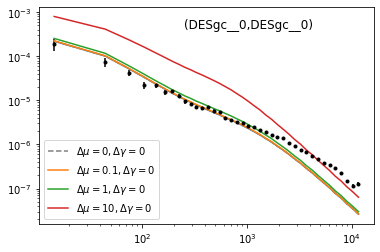

In [16]:
f, ax = plt.subplots(1, 1)
trs = ('DESgc__0', 'DESgc__0')
plot_Cell_data_ax(ax, s, trs)
plot_Cell_th_ax(ax, s, trs, th, label='$\Delta\mu=0, \Delta\gamma=0$', color='gray', ls='--')
plot_Cell_th_ax(ax, s, trs, th2, label='$\Delta\mu=0.1, \Delta\gamma=0$')
plot_Cell_th_ax(ax, s, trs, th3, label='$\Delta\mu=1, \Delta\gamma=0$')
plot_Cell_th_ax(ax, s, trs, th4, label='$\Delta\mu=10, \Delta\gamma=0$')
# plot_Cell_th_ax(ax, s, trs, th5, label='$\Delta\mu=1000, \Delta\gamma=1$')
# plot_Cell_th_ax(ax, s, trs, thSDBF, label='$SD BF (\Delta\mu=339, \Delta\gamma=0.7$', color='k')

ax.set_yscale('log')
ax.legend(loc='lower left')
for n1, n2 in s.get_tracer_combinations()[:1]:
    i1 = int(n1[-1])
    i2 = int(n2[-1])
#     ax = axes[i2, i1]
#     if i2 == 3:
#         ax.set_xlabel(r'$\ell$', fontsize=14)
#     if i1 == 0:
#         ax.set_ylabel(r'$C_\ell$', fontsize=14)
plt.show()

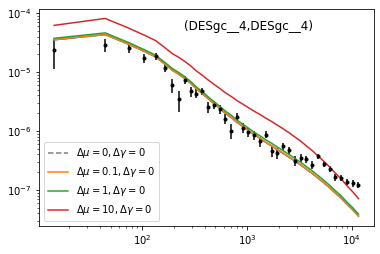

In [18]:
f, ax = plt.subplots(1, 1)
trs = ('DESgc__4', 'DESgc__4')
plot_Cell_data_ax(ax, s, trs)
plot_Cell_th_ax(ax, s, trs, th, label='$\Delta\mu=0, \Delta\gamma=0$', color='gray', ls='--')
plot_Cell_th_ax(ax, s, trs, th2, label='$\Delta\mu=0.1, \Delta\gamma=0$')
plot_Cell_th_ax(ax, s, trs, th3, label='$\Delta\mu=1, \Delta\gamma=0$')
plot_Cell_th_ax(ax, s, trs, th4, label='$\Delta\mu=10, \Delta\gamma=0$')
# plot_Cell_th_ax(ax, s, trs, thSDBF, label='$SD BF (\Delta\mu=339, \Delta\gamma=0.7$', color='k')

ax.set_yscale('log')
ax.legend(loc='lower left')
# for n1, n2 in s.get_tracer_combinations()[:1]:
#     i1 = int(n1[-1])
#     i2 = int(n2[-1])
# #     ax = axes[i2, i1]
# #     if i2 == 3:
# #         ax.set_xlabel(r'$\ell$', fontsize=14)
# #     if i1 == 0:
# #         ax.set_ylabel(r'$C_\ell$', fontsize=14)
plt.show()

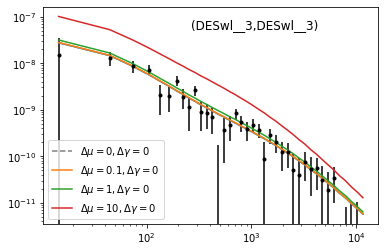

In [20]:
f, ax = plt.subplots(1, 1)
trs = ('DESwl__3', 'DESwl__3')
plot_Cell_data_ax(ax, s, trs)
plot_Cell_th_ax(ax, s, trs, th, label='$\Delta\mu=0, \Delta\gamma=0$', color='gray', ls='--')
plot_Cell_th_ax(ax, s, trs, th2, label='$\Delta\mu=0.1, \Delta\gamma=0$')
plot_Cell_th_ax(ax, s, trs, th3, label='$\Delta\mu=1, \Delta\gamma=0$')
plot_Cell_th_ax(ax, s, trs, th4, label='$\Delta\mu=10, \Delta\gamma=0$')
# plot_Cell_th_ax(ax, s, trs, thSDBF, label='$SD BF (\Delta\mu=339, \Delta\gamma=0.7$', color='k')

ax.set_yscale('log')
ax.legend(loc='lower left')


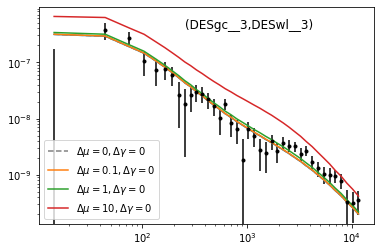

In [21]:
f, ax = plt.subplots(1, 1)
trs = ('DESgc__3', 'DESwl__3')
plot_Cell_data_ax(ax, s, trs)
plot_Cell_th_ax(ax, s, trs, th, label='$\Delta\mu=0, \Delta\gamma=0$', color='gray', ls='--')
plot_Cell_th_ax(ax, s, trs, th2, label='$\Delta\mu=0.1, \Delta\gamma=0$')
plot_Cell_th_ax(ax, s, trs, th3, label='$\Delta\mu=1, \Delta\gamma=0$')
plot_Cell_th_ax(ax, s, trs, th4, label='$\Delta\mu=10, \Delta\gamma=0$')
# plot_Cell_th_ax(ax, s, trs, thSDBF, label='$SD BF (\Delta\mu=339, \Delta\gamma=0.7$', color='k')

ax.set_yscale('log')
ax.legend(loc='lower left')


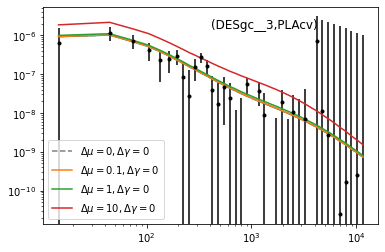

In [22]:
f, ax = plt.subplots(1, 1)
trs = ('DESgc__3', 'PLAcv')
plot_Cell_data_ax(ax, s, trs)
plot_Cell_th_ax(ax, s, trs, th, label='$\Delta\mu=0, \Delta\gamma=0$', color='gray', ls='--')
plot_Cell_th_ax(ax, s, trs, th2, label='$\Delta\mu=0.1, \Delta\gamma=0$')
plot_Cell_th_ax(ax, s, trs, th3, label='$\Delta\mu=1, \Delta\gamma=0$')
plot_Cell_th_ax(ax, s, trs, th4, label='$\Delta\mu=10, \Delta\gamma=0$')
# plot_Cell_th_ax(ax, s, trs, thSDBF, label='$SD BF (\Delta\mu=339, \Delta\gamma=0.7$', color='k')

ax.set_yscale('log')
ax.legend(loc='lower left')
